# Database Connection - Linear Regression - Spliting dataset into Train and Test sets

### Outline:

- connect to Postgres Database in AWS.
- load economic features and target table into Dataframe
- additional Data manipulation in Dataframe
- train model and evaluate results

## Import Dependencies
**config.py**  file is needed to connect to AWS database

You may need to run these pip install in the correct conda environment:

`$   pip install psycopg2`

`$   pip install psycopg2-binary `

In [1]:
%matplotlib inline

In [2]:
# Import dependencies
from sqlalchemy import inspect, create_engine
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
import config as creds
import pandas as pd

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import sklearn.preprocessing as preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import sklearn.datasets as datasets

# For splitting of data into train and test set
from sklearn.model_selection import train_test_split

# Metrics for Evaluation of model Accuracy and F1-score
from sklearn.metrics  import f1_score,accuracy_score, mean_absolute_error, mean_squared_error, r2_score
import sklearn.metrics as metrics

In [3]:
#!pip install psycopg2

In [4]:
#!pip install psycopg2-binary 

## Connect to postgres database in AWS, read data into a Dataframe

In [3]:
# Create engine
engine = create_engine(f'postgresql://{creds.PGUSER}:{creds.PGPASSWORD}@{creds.PGHOST}:5432/{creds.PGDATABASE}')

In [4]:
# Create our session (link) from Python to the DB
session = Session(bind=engine.connect())

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# List tables in database
inspect(engine).get_table_names()

['economic_features_full',
 'features_table',
 'target_table',
 'economic_features',
 'high_low_poverty']

In [7]:
# List columns in a specific table ('min_wage')
[column['name'] for column in inspect(engine).get_columns('economic_features')]

['year',
 'state',
 'population_million',
 'education_million',
 'welfare_million',
 'crime_rate',
 'unemployment_rate',
 'divorce_rate_per_1000_people',
 'homeownership_rate',
 'minimum_wage_effective',
 'cpi_average',
 'inflation_rate',
 'avg_wage_index',
 'poverty_rate']

In [8]:
# Defining function that takes in a table name and outputs a dataframe
def db_reader(tablename):
    table_df = pd.read_sql_table(f'{tablename}', engine)
    return table_df

In [9]:
# Reading a database table into a dataframe
econ_features_full = db_reader('economic_features_full')
econ_features_full.head()

,year,state,population_million,education_million,welfare_million,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,poverty_rate
0,1970,National,203.302,56456.0,18738.8,363.5,NaN,3.50,NaN,1.382353,38.8,5.8,6186.24,17.18
1,1971,National,205.515,63469.0,27364.3,396.0,NaN,3.75,NaN,1.382353,40.5,4.3,6497.08,17.05
2,1972,National,207.752,71351.0,30594.3,401.0,NaN,4.00,NaN,1.623529,41.8,3.3,7133.80,16.12
3,1973,National,210.013,75849.0,28944.9,417.4,NaN,4.25,NaN,1.623529,44.4,6.2,7580.16,15.13
4,1974,National,212.299,81440.0,34816.4,461.1,NaN,4.50,NaN,1.623529,49.3,11.1,8030.76,15.86


## Additional data processing

In [10]:
# Calculate additional features

econ_features_full['education_per_capita'] = econ_features_full['education_million'] / econ_features_full['population_million']
econ_features_full['welfare_per_capita'] = econ_features_full['welfare_million'] / econ_features_full['population_million']


In [11]:
# Drop the non-beneficial columns
columns_to_drop = ['education_million','welfare_million','population_million']
model_df = econ_features_full.drop(columns=columns_to_drop, axis=1)

# Drop 'District of Columbia' information
model_df.drop(model_df[model_df['state']=='District of Columbia'].index, inplace=True)

model_df.head()

,year,state,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,poverty_rate,education_per_capita,welfare_per_capita
0,1970,National,363.5,NaN,3.50,NaN,1.382353,38.8,5.8,6186.24,17.18,277.695251,92.172236
1,1971,National,396.0,NaN,3.75,NaN,1.382353,40.5,4.3,6497.08,17.05,308.829039,133.149892
2,1972,National,401.0,NaN,4.00,NaN,1.623529,41.8,3.3,7133.80,16.12,343.443144,147.263564
3,1973,National,417.4,NaN,4.25,NaN,1.623529,44.4,6.2,7580.16,15.13,361.163357,137.824325
4,1974,National,461.1,NaN,4.50,NaN,1.623529,49.3,11.1,8030.76,15.86,383.609909,163.997004


## Model for 1 state

In [12]:
# List of states
model_df.state.unique()

array(['National', 'Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware', 'Nebraska',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Wisconsin', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wyoming'], dtype=object)

In [13]:
# Pick data for 1 state
state_to_model = 'Texas'
model_state_df = model_df.loc[model_df['state']==state_to_model].dropna().set_index('year')
model_state_df.drop(columns=['state'], inplace=True)
model_state_df

,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,poverty_rate,education_per_capita,welfare_per_capita
year,,,,,,,,,,,
1984,505.0,6.1,4.9778,62.5,3.35,103.900,4.3,16135.07,22.4,841.894723,201.839728
1985,550.0,7.0,4.9222,60.5,3.35,107.600,3.5,16822.51,22.4,915.642889,205.628095
1986,658.9,8.8,4.8667,61.0,3.35,109.600,1.9,17321.82,22.6,986.350711,224.000000
1987,631.1,8.5,4.8111,61.1,3.35,113.600,3.7,18426.51,22.7,988.999255,272.547802
1988,652.6,7.4,4.7556,59.9,3.35,118.300,4.1,19334.04,22.3,1021.018603,264.812443
1989,658.5,6.7,4.7000,61.0,3.35,124.000,4.8,20099.55,21.8,1079.290508,271.919942
1990,761.4,6.4,4.7000,59.7,3.35,130.700,5.4,21027.98,21.6,1150.774121,323.541532
1991,840.1,7.0,4.6429,59.0,3.80,136.200,4.2,21811.60,21.4,1158.507325,392.617372
1992,806.3,7.7,4.5857,58.3,4.25,140.300,3.0,22935.42,21.1,1248.067578,257.447169


In [16]:
# Define X and y variables
X = model_state_df.drop(["poverty_rate"], axis=1)  #.values.reshape(-1, 1)
y = model_state_df["poverty_rate"]
print(f'X shape: {X.shape}')
X.head()

X shape: (36, 10)


,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,education_per_capita,welfare_per_capita
year,,,,,,,,,,
1984,505.0,6.1,4.9778,62.5,3.35,103.9,4.3,16135.07,841.894723,201.839728
1985,550.0,7.0,4.9222,60.5,3.35,107.6,3.5,16822.51,915.642889,205.628095
1986,658.9,8.8,4.8667,61.0,3.35,109.6,1.9,17321.82,986.350711,224.000000
1987,631.1,8.5,4.8111,61.1,3.35,113.6,3.7,18426.51,988.999255,272.547802
1988,652.6,7.4,4.7556,59.9,3.35,118.3,4.1,19334.04,1021.018603,264.812443


In [18]:
model_state_df.dtypes

crime_rate                      float64
unemployment_rate               float64
divorce_rate_per_1000_people    float64
homeownership_rate              float64
minimum_wage_effective          float64
cpi_average                     float64
inflation_rate                  float64
avg_wage_index                  float64
poverty_rate                    float64
education_per_capita            float64
welfare_per_capita              float64
dtype: object

In [18]:
#  CHECK IF THIS IS NEEDED ********************************************
# std = preprocessing.StandardScaler()
# X is a matrix
#std.fit(X)
#X_std = std.transform(X)

In [19]:
# Create a model with scikit-learn
model = LinearRegression()

In [20]:
# Test the model by using train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
model.fit(X_train, y_train)

LinearRegression()

In [21]:
# Fit the data into the model
# By convention, X is capitalized and y is lowercase
#model.fit(X, y)

In [21]:
# We use the predict() on the model to predict the output
# The model creates predicted y values based on X values

#  Predict using all X values for ease of plotting.
y_pred = model.predict(X)
print(y_pred.shape)
print(X.shape)

# Use y_pred_test to plot testing points
y_pred_test = model.predict(X_test)

(36,)
(36, 10)


In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
print(f'Mean absolute error: {mean_absolute_error(y_test,y_pred_test)}')
print(f'Mean square error: {mean_squared_error(y_test,y_pred_test)}')
print(f'r2 score: {r2_score(y_test,y_pred_test)}')
print(f'Coefficients: {model.coef_}')
print(f'Intercept: {model.intercept_}')

Mean absolute error: 0.48186573556839885
Mean square error: 0.3779708271975897
r2 score: 0.9574589224264535
Coefficients: [-7.61813651e-04  7.12877331e-01 -1.47550895e+00 -1.77030692e-01
 -7.64462543e-01 -1.97552731e-02  2.49500669e-01  8.75851667e-05
 -2.03153530e-03 -2.49864425e-03]
Intercept: 40.172797845154335


In [23]:
model_state_df['predicted_poverty'] = y_pred
model_state_df.head()

,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,poverty_rate,education_per_capita,welfare_per_capita,predicted_poverty
year,,,,,,,,,,,,
1984,505.0,6.1,4.9778,62.5,3.35,103.9,4.3,16135.07,22.4,841.894723,201.839728,21.385286
1985,550.0,7.0,4.9222,60.5,3.35,107.6,3.5,16822.51,22.4,915.642889,205.628095,22.056920
1986,658.9,8.8,4.8667,61.0,3.35,109.6,1.9,17321.82,22.6,986.350711,224.000000,22.665983
1987,631.1,8.5,4.8111,61.1,3.35,113.6,3.7,18426.51,22.7,988.999255,272.547802,22.877784
1988,652.6,7.4,4.7556,59.9,3.35,118.3,4.1,19334.04,22.3,1021.018603,264.812443,22.412284


In [24]:
X_test

,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,education_per_capita,welfare_per_capita
year,,,,,,,,,,
2015,412.7,4.5,3.1000,61.9,7.25,237.017,0.1,48098.63,2933.881830,335.964178
1990,761.4,6.4,4.7000,59.7,3.35,130.700,5.4,21027.98,1150.774121,323.541532
1984,505.0,6.1,4.9778,62.5,3.35,103.900,4.3,16135.07,841.894723,201.839728
2018,412.9,3.9,2.9000,62.7,7.25,251.107,2.4,52145.80,3223.053275,355.909170
1992,806.3,7.7,4.5857,58.3,4.25,140.300,3.0,22935.42,1248.067578,257.447169
1993,762.1,7.2,4.5286,58.7,4.25,144.500,3.0,23132.67,1346.556687,288.302702
2011,408.6,8.0,3.6000,64.3,7.25,224.939,3.2,42979.61,2884.933323,523.290182
2010,448.4,8.2,3.6000,65.3,7.25,218.056,1.6,41673.83,2967.130180,548.474764


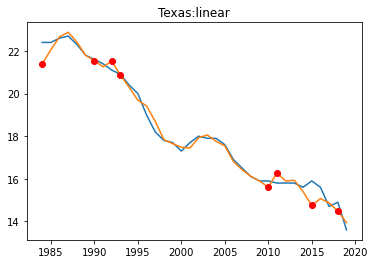

In [25]:
# Plot the results. The best fit line is red.
#model_state_df.plot(y=['poverty_rate','predicted_poverty'], use_index=True, title=state_to_model )
plt.plot(model_state_df.index.values, model_state_df['poverty_rate'],
         model_state_df.index.values,model_state_df['predicted_poverty'])
plt.plot(X_test.index, y_pred_test, color='r', marker='o', lw=0)
plt.title(f'{state_to_model}:linear')
plt.show()

#plt.plot(X, y_pred, color='red')
#plt.show()

In [26]:
# The slope
# The y-intercept
print(model.coef_)
print(model.intercept_)

[-7.61813651e-04  7.12877331e-01 -1.47550895e+00 -1.77030692e-01
 -7.64462543e-01 -1.97552731e-02  2.49500669e-01  8.75851667e-05
 -2.03153530e-03 -2.49864425e-03]
40.172797845154335


## Create Function

In [27]:
# create, train and test a model on dataframe df, filtering on state using the model_type

def run_model(df, model_type='linear'):
    training_size = 0.8
    result_df = pd.DataFrame()
    rows_plots = len(df.state.unique())
    fig, ax = plt.subplots(rows_plots, 1 , figsize=(20, 5*rows_plots))
    
    for row, state in enumerate(df.state.unique()):
        m_df = df.loc[df['state']==state].dropna().set_index('year')
        m_df.drop(columns=['state'], inplace=True)

    # Define X and y variables
        X = m_df.drop(["poverty_rate"], axis=1)
        y = m_df["poverty_rate"]

    # Create a model with scikit-learn
        if model_type=='linear':
            model = LinearRegression()
        elif model_type =='ridge':
            model = Ridge(alpha=0.5)
        elif model_type == 'lasso':
            model = Lasso(alpha=0.1, max_iter=1500, tol=0.01)
        else:
            model = LinearRegression()
    
    # Test the model by using train and test dataset
    # Fit the data into the model
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=training_size)
        model.fit(X_train, y_train)
    
    # We use the predict() on the model to predict the output
    # The model creates predicted y values based on X values
        y_pred = model.predict(X)
        m_df['predicted_poverty'] = y_pred
    
    # Use y_pred_test to plot testing points
        y_pred_test = model.predict(X_test)
    
    #m_df.plot(y=['poverty_rate','predicted_poverty'], use_index=True, title=f'{state}:{model_type}')
        ax[row].plot(m_df.index.values, m_df['poverty_rate'],
             m_df.index.values, m_df['predicted_poverty'])
        ax[row].plot(X_test.index, y_pred_test, color='r', marker='o', lw=0)
        ax[row].set_title(f'{state}:{model_type}')
    
        result = { 'State': state,
                    'Model': model_type,
                    'Mean absolute error': mean_absolute_error(y_test,y_pred_test),
                    'Mean square error': mean_squared_error(y_test,y_pred_test),
                    'r2 score': r2_score(y_test,y_pred_test),
                    'Coefficients': model.coef_,
                    'Intercept': model.intercept_
                  }
        result_df = result_df.append(result, ignore_index=True)
    plt.show()
    return result_df
    

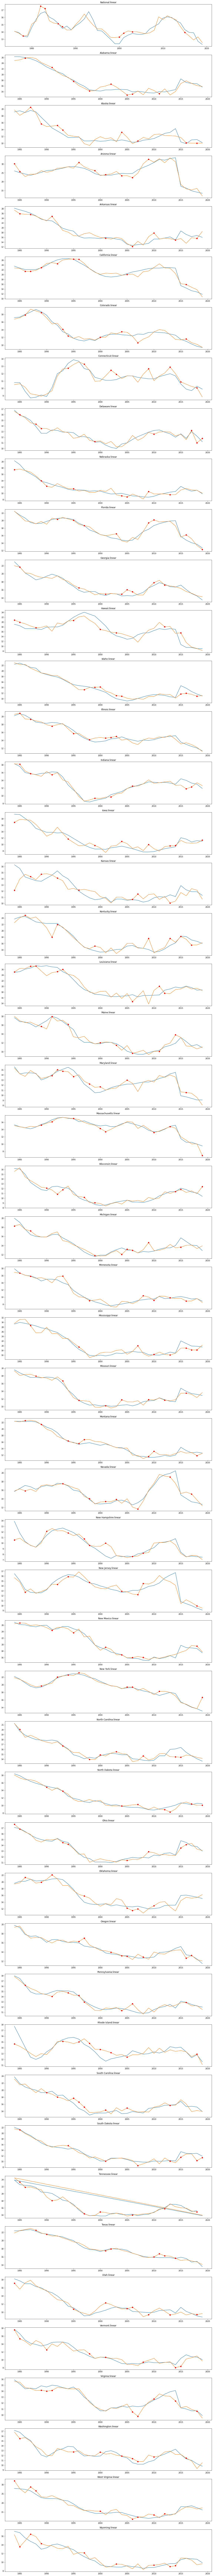

In [28]:
result_df = pd.DataFrame()

result = run_model(model_df, 'linear')
result_df = result_df.append(result, ignore_index=True)


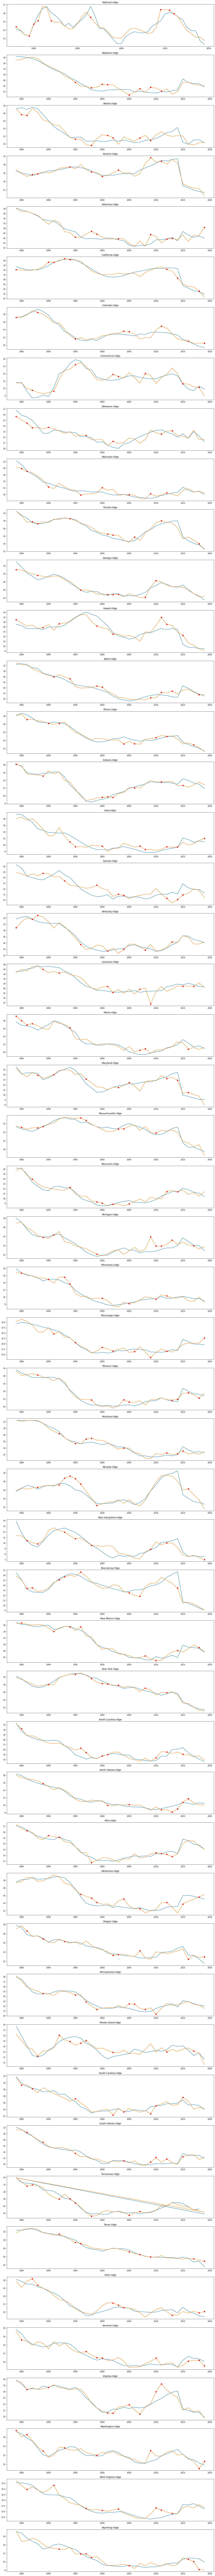

In [29]:
result = run_model(model_df, 'ridge')
result_df = result_df.append(result, ignore_index=True)

In [30]:
result_df.shape

(102, 7)

In [33]:
result3_df = pd.DataFrame()
result3_df = result_df[result_df.Model=='linear'].copy()
result3_df.dtypes
r2_linear = result3_df['r2 score'].tolist()
r2_ridge = result_df.loc[result_df.Model=='ridge']['r2 score'].tolist()
result3_df['r2 score ridge']=r2_ridge
result3_df['delta r2']=result3_df['r2 score']-result3_df['r2 score ridge']
result3_df= result3_df.set_index('State').sort_values(by='delta r2', ascending=False)
result3_df

,Coefficients,Intercept,Mean absolute error,Mean square error,Model,r2 score,r2 score ridge,delta r2
State,,,,,,,,
Arkansas,"[0.011798428810551714, 2.055584484483834, 0.40...",23.209992,1.064344,1.817527,linear,0.934847,-2.863379,3.798226
Alabama,"[0.003381250652783237, 1.0872231313846645, -4....",95.410003,0.869882,1.178886,linear,0.932702,-0.408918,1.341621
Oklahoma,"[0.022323433956866912, 1.2354678767650287, -1....",53.874423,0.983062,1.145854,linear,0.918335,-0.186760,1.105095
Nevada,"[-0.0044800599739628225, 0.4136594337526327, -...",28.527806,0.794986,1.011359,linear,0.834203,-0.152227,0.986431
New Jersey,"[-0.023679903086642855, 0.3016478753482303, -0...",20.821955,0.586802,0.455568,linear,0.874908,0.264587,0.610322
Michigan,"[0.00012095403513504341, 0.4304840793397785, -...",67.618419,1.067529,1.764349,linear,0.732750,0.161434,0.571316
Iowa,"[0.004483507944069872, 0.8506276602001909, -3....",85.618042,1.243825,2.131183,linear,0.829360,0.383928,0.445432
Wyoming,"[-0.00397524169860858, 0.10416328305162656, 1....",62.318337,1.188680,2.148575,linear,0.721304,0.366292,0.355012
National,"[0.003589238774122528, 5.922269923871787, 1.38...",-3.565185,0.436685,0.297810,linear,0.847432,0.510600,0.336832


<AxesSubplot:ylabel='State'>

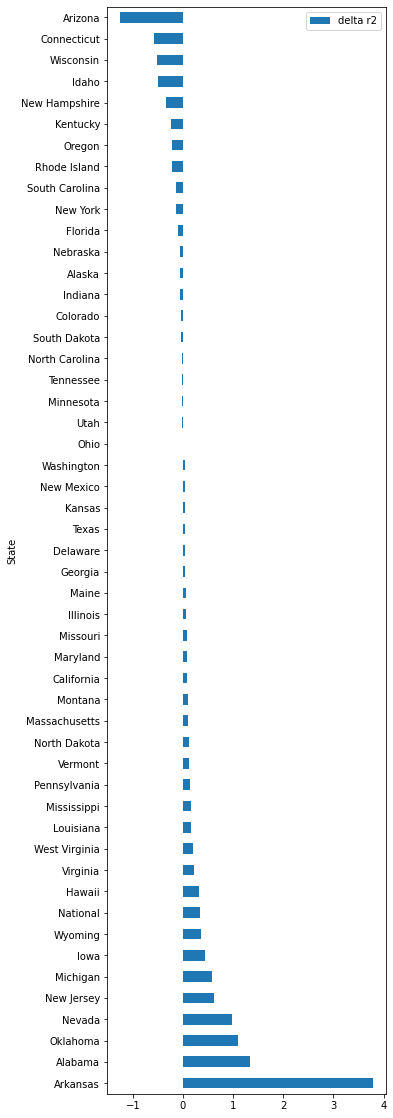

In [34]:
result3_df.plot(y='delta r2',kind='barh',use_index=True, figsize=(5,20))